TODO:
- try soft f1 loss function
- test weighted loss function to see if working how i want
- one hot vs label binarizer
- early stopping (less epochs)

In [1]:
# !pip install pandas
# !pip install torch
# !pip install tqdm  # pip install ipywidgets or something
!pip install wandb &> /dev/null
# !pip install gensim &> /dev/null
# !pip install torchmetrics &> /dev/null

In [2]:
USING_WANDB = True  # Set to false if not Peter

if USING_WANDB:
    import wandb
    wandb.login()
    # !wandb login

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = "/content/drive/MyDrive/dna_ml_model_data"
accessible_file = f"{data_folder}/accessible.fasta"
notaccessible_file = f"{data_folder}/notaccessible.fasta"
reduced_nonaccessible_file = f"{data_folder}/reduced_nonaccessible.fasta"
comp_file = f"{data_folder}/test.fasta"
# rest_notaccessible_file = f"{data_folder}/rest_nonaccessible.fasta"

DATA_ZIP_FILE = "Files.zip"
LINES_PER_SEQUENCE = 4
ACCESSIBLE_LABEL = 1
NOT_ACCESSIBLE_LABEL = 0
TEMP_SPLIT = 0.30  # validation + test
TEST_SPLIT = 0.15
PRETRAINED_DIR = "pretrained"
SOLUTION_FILE = "predictions.csv"

In [36]:
import dna_dataset, utils, CNNModel # , LSTMCNNModel, constants
import torch.nn as nn, torch.optim as optim, torch
from tqdm.notebook import tqdm
import importlib, os, numpy as np, pandas as pd, random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# from torchmetrics.functional import f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

importlib.reload(dna_dataset)
importlib.reload(utils)
importlib.reload(CNNModel)
# importlib.reload(LSTMCNNModel)
# importlib.reload(constants)

<module 'CNNModel' from '/content/CNNModel.py'>

In [8]:
# Unzip the zip file
# !unzip $DATA_ZIP_FILE

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# Read the data from data files
acc_sequences, acc_labels, _ = dna_dataset.read_data_file(accessible_file, accessible=True, shuffle=True)
# not_sequences, not_labels, _ = dna_dataset.read_data_file(reduced_nonaccessible_file, accessible=False, shuffle=True)

In [11]:
not_sequences, not_labels, _ = dna_dataset.read_data_file(notaccessible_file, accessible=False, shuffle=True)

In [12]:
num_acc = len(acc_sequences)
num_not = len(not_sequences)
full_size = num_acc + num_not
print(f"full size: {full_size} num_acc: {num_acc} num_not: {num_not}")

# Split accessible data into train val test split
acc_seq_train, acc_seq_temp, acc_lab_train, acc_lab_temp = train_test_split(acc_sequences, acc_labels, test_size=TEMP_SPLIT, random_state=1)
acc_seq_val, acc_seq_test, acc_lab_val, acc_lab_test = train_test_split(acc_seq_temp, acc_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=1)

# Split not accessible data into train val test split
not_seq_train, not_seq_temp, not_lab_train, not_lab_temp = train_test_split(not_sequences, not_labels, test_size=TEMP_SPLIT, random_state=1)
not_seq_val, not_seq_test, not_lab_val, not_lab_test = train_test_split(not_seq_temp, not_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=1)

assert(len(acc_sequences) == len(acc_labels) == len(acc_seq_train) + len(acc_seq_val) + len(acc_seq_test))
assert(len(not_sequences) == len(not_labels) == len(not_lab_train) + len(not_lab_val) + len(not_lab_test))

full size: 525688 num_acc: 47239 num_not: 478449


Upsample or Downsample the dataset  
(AFTER splitting to train/validation/test to prevent data leakage)

In [13]:
UPSAMPLE = False
DOWNSAMPLE = False

if UPSAMPLE:
    num_diff = len(not_seq_train) - len(acc_seq_train)
    # upscale the minority
    upsampled_acc_seq, upsampled_acc_lab = resample(acc_seq_train, acc_lab_train, n_samples=num_diff, random_state=1)
    actual_acc_seq_train = acc_seq_train + upsampled_acc_seq
    actual_acc_lab_train = acc_lab_train + upsampled_acc_lab
else:
    actual_acc_seq_train = acc_seq_train
    actual_acc_lab_train = acc_lab_train
# consider upweighting for calibration
if DOWNSAMPLE:
    # downsample the majority
    # downsampled_not_seq, downsampled_not_lab = resample(not_seq_train, not_lab_train, n_samples=len(acc_seq_train), random_state=1)
    # just take the first part len(acc_seq_train) samples
    actual_not_seq_train = not_seq_train[:len(acc_seq_train)]
    actual_not_lab_train = not_lab_train[:len(acc_seq_train)]
    # Adding rest of data to test and val
    rest_not_sequences, rest_not_labels = not_seq_train[len(acc_seq_train):], not_lab_train[len(acc_seq_train):]
    print("Rest not seq and labs ", len(rest_not_sequences), len(rest_not_labels))
    assert(len(rest_not_sequences) + len(actual_not_seq_train) == len(not_seq_train))
    # ensure the data is now equal
    assert(len(actual_acc_seq_train) == len(actual_not_seq_train))
else:
    actual_not_seq_train = not_seq_train
    actual_not_lab_train = not_lab_train
print("Actual train not seq and labs ", len(actual_not_seq_train), len(actual_not_lab_train))
print("Actual train acc seq and labs ", len(actual_acc_seq_train), len(actual_acc_lab_train))

Actual train not seq and labs  334914 334914
Actual train acc seq and labs  33067 33067


In [14]:
# Create the (shuffled) datasets, after appending the lists
sequences_train = actual_acc_seq_train + actual_not_seq_train
labels_train = actual_acc_lab_train + actual_not_lab_train
# sequences_train, labels_train = dna_dataset.shuffle_lists(sequences_train, labels_train)
# df_train = pd.DataFrame({"sequences": sequences_train, "labels": labels_train})
train_dataset = dna_dataset.DNADataset(sequences_train, labels_train)
num_train = len(train_dataset)
print("train samples", num_train)
assert(len(sequences_train) == len(labels_train) == num_train)

sequences_val = acc_seq_val + not_seq_val
labels_val = acc_lab_val + not_lab_val
val_dataset = dna_dataset.DNADataset(sequences_val, labels_val)
print("val samples", len(val_dataset))

sequences_test = acc_seq_test + not_seq_test
labels_test = acc_lab_test + not_lab_test
test_dataset = dna_dataset.DNADataset(sequences_test, labels_test)
print("test samples", len(test_dataset))

if DOWNSAMPLE:
    rest_notacc_dataset = dna_dataset.DNADataset(rest_not_sequences, rest_not_labels)
    print("rest not samples", len(rest_notacc_dataset))

train samples 367981
val samples 78853
test samples 78854


In [15]:
# Check things are the right size
if DOWNSAMPLE:
  print(len(sequences_train) + len(sequences_val) + len(sequences_test) + len(rest_not_sequences), full_size)
  assert(len(sequences_train) + len(sequences_val) + len(sequences_test) + len(rest_not_sequences) == full_size)
elif UPSAMPLE:
  pass
else:
  print(len(sequences_train) + len(sequences_val) + len(sequences_test), full_size)
  assert(len(sequences_train) + len(sequences_val) + len(sequences_test) == full_size)

525688 525688


In [16]:
# ensure the DNADataset is loaded properly
print('total sequences', full_size)
print('num accessible', num_acc)
print('num not accessible', num_not)
i = 0
print(f"example entry {i}")
item = train_dataset[i]
# print(item['sequence'])  # long answer
print("label", item['label'])
# ensure dataset was shuffled properly
# check that not all the accessible labels are at the front
for i in range(len(train_dataset)):
    if train_dataset[i]['label'] != ACCESSIBLE_LABEL:
        print('shuffled')
        break
# Balanced: total sequences 94478  num accessible 47239  num not accessible 47239
# Full (imbalanced) total sequences 525688  num accessible 47239  num not accessible 478449

total sequences 525688
num accessible 47239
num not accessible 478449
example entry 0
label 0
shuffled


In [17]:
# # Free up memory
# del sequences_train, labels_train, sequences_val, labels_val, sequences_test, labels_test
# del acc_seq_train, not_seq_train, acc_lab_train, not_lab_train
# del acc_seq_val, not_seq_val, acc_lab_val, not_lab_val
# del acc_seq_test, not_seq_test, acc_lab_test, not_lab_test

In [25]:
# Initialize model
importlib.reload(dna_dataset)
importlib.reload(utils)
importlib.reload(CNNModel)
torch.manual_seed(0)

kernel_size = 3     # 2  # should use odd size
embed_dim = 4  # 4
conv_filters = [64,128]
num_filters1 = 64  # 64
num_filters2 = 128  # 128
pool_kernel_size = 2  # 2
hidden_dense1 = 64  # 64
hidden_dense2 = 32  # 32
linear_neurons = [64, 32]
dropout_rate_Dense = 0.5  # .5

# insert torch model here, that takes sequence as input and output a label 0 or 1
# CNN = CNNModel.CNNModel(kernel_size, embed_dim, num_filters1, num_filters2, pool_kernel_size,
#                            hidden_dense1, hidden_dense2, dropout_rate_Dense)
CNN = CNNModel.CNNModel(kernel_size, embed_dim, conv_filters, pool_kernel_size,
                           linear_neurons, dropout_rate_Dense)

CNN.to(device)  # quiet output

CNNModel(
  (Convs): ModuleList(
    (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linears): ModuleList(
    (0): Linear(in_features=6400, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (dropout_Dense): Dropout(p=0.5, inplace=False)
)

In [26]:
# Figure out why list is not working. maybe it's not updating weights?

In [27]:
# CNNModel(
#   (Conv1): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
#   (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (Conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
#   (flatten): Flatten(start_dim=1, end_dim=-1)
#   (linear1): Linear(in_features=6400, out_features=64, bias=True)
#   (linear2): Linear(in_features=64, out_features=32, bias=True)
#   (linear3): Linear(in_features=32, out_features=1, bias=True)
#   (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (dropout_Dense): Dropout(p=0.5, inplace=False)
#   (sigmoid): Sigmoid()
# )

Notes: Based on a test, using [1,pos_weight] gives the same results as [weight0, weight1]

In [28]:
# Loss Function

# WEIGHTED_LOSS = "Inverse Class Frequency Weight"
# WEIGHTED_LOSS = "Balanced Class Weights"
# WEIGHTED_LOSS = None
WEIGHTED_LOSS = "sklearn type weight"
# WEIGHTED_LOSS = "Inverse Sqrt Weight"

# https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4

weight_class0 = 1

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
if WEIGHTED_LOSS == "sklearn type weight":
    weight_class0 = torch.Tensor([num_train / len(actual_not_seq_train) * 2]).to(device)
    weight_class1 = torch.Tensor([num_train / len(actual_acc_seq_train) * 2]).to(device)
    # = (n_0 + n_1) / (2.0 * n_1)
# Balanced class weights: weight = total_samples / (num_classes * frequency)
elif WEIGHTED_LOSS == "Balanced Class Weight":
    weight_class1 = num_train / len(actual_acc_seq_train) * 2
# Inverse class frequency: weight = 1 / frequency
elif WEIGHTED_LOSS == "Inverse Class Frequency Weight":
    weight_class1 = len(actual_not_seq_train) / len(actual_acc_seq_train)
# Slightly worse then the rest
elif WEIGHTED_LOSS == "Inverse Sqrt Weight":
    weighted_class0 = 1 / np.sqrt(len(actual_not_seq_train))
    weighted_class1 = 1 / np.sqrt(len(actual_acc_seq_train))

if WEIGHTED_LOSS != None:
    # loss_fn = nn.BCELoss()
    pos_weight = weight_class1 / weight_class0
    print(f"pos_weight {pos_weight}")
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]).to(device))
    # loss_fn = utils.weighted_binary_cross_entropy
    # loss_fn = nn.BCELoss(weight=torch.Tensor([weight_class0, weight_class1]))
    try:
      print("weight for class 0", weight_class0)
    except:
      pass
    print("weight for class 1", weight_class1)
else:
    loss_fn = nn.BCEWithLogitsLoss()  # (reduction='none') ??
    # loss_fn = nn.BCELoss()
    # loss_fn = utils.macro_double_soft_f1

if loss_fn.__class__.__name__ == "BCELoss" or loss_fn.__class__.__name__ == "function":
    model = nn.Sequential(CNN, nn.Sigmoid())  # Add Softmax to model if using BCELoss
    print("Added sigmoid")
else:
    model = CNN
model.to(device);

pos_weight tensor([10.1283])
weight for class 0 tensor([2.1975])
weight for class 1 tensor([22.2567])


In [29]:
# parameters
epochs = 20
batch_size = 128
learning_rate = .0001
weight_decay = .01
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # weight_decay=1
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=.01)  # weight_decay=1
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # pretty bad

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g) # shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
# del train_dataset, val_dataset, test_dataset

In [30]:
# USING_WANDB = True

In [ ]:
# TRAINING LOOP
# USING_WANDB = False
if USING_WANDB:
    note = f"test-list-{weight_decay}-weight-decay-adamW-{WEIGHTED_LOSS}"
    # note = f"{optimizer.__class__.__name__}-{kernel_size}-kernel-{num_filters1}-{num_filters2}-conv-{hidden_dense1}-{hidden_dense2}-dense" # "lstm_no_dropout" # "0.5_dropout"
    wandb.init(
        project="dna_ml_model",
        # name=f"experiment_{run}"
        name=f"{note}",
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": epochs,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "loss fn": loss_fn.__class__.__name__,
            "weighted loss1": WEIGHTED_LOSS,
            "notes": note
    })


# step = 0
best_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")

    running_loss = 0.0
    running_corrects = 0.0

    CM = 0  # confusion matrix

    model.train()
    for batch in train_loader:  # tqdm()

        samples, labels = batch["sequence"].to(device), batch['label'].to(device)

        outputs = model(samples).flatten()

        labels = labels.reshape(-1,1).float().flatten()

        # Backpropagation and gradient descent

        # if USE_WEIGHTED_LOSS:
        #     acc_weight = (labels==ACCESSIBLE_LABEL) * weight_class0
        #     not_weight = (labels==NOT_ACCESSIBLE_LABEL) * weight_class1
        #     acc_weight[acc_weight==0] = 1
        #     not_weight[not_weight==0] = 1
        #     outputs *= acc_weight
        #     outputs *= not_weight
        if loss_fn.__class__.__name__ == "function":  # custom loss function
            loss = loss_fn(outputs, labels, [weight_class0, weight_class1])
        else:
            loss = loss_fn(outputs, labels) #, [weight_class0, weight_class1])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # reset gradients before next iteration

        running_loss += loss.item() * samples.size(0)  # loss per sample times batch size

        preds = utils.get_preds(outputs)
        running_corrects += torch.sum(preds == labels.data).item()
        CM += confusion_matrix(labels.cpu().flatten().detach().numpy(), preds.cpu().flatten().detach().numpy())

    # Calculate recall, precision, f1 score
    acc_score, precision, recall, f1 = utils.compute_metrics(CM)

    # if step % n_eval == 0:
    # Compute training loss and accuracy.
    with torch.no_grad():
        model.eval()
        val_loss, val_acc, val_precision, val_recall, val_f1 = utils.evaluate(val_loader, model, loss_fn, device)

    epoch_loss = running_loss / num_train
    epoch_acc = running_corrects / num_train
    print(f"""Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}
          Precision {precision:.4f} Recall: {recall:.4f}""")
    print(f"""Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}
          Precision {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}""")

    # # deep copy the model
    # if val_accuracy > best_acc:
    #     best_acc = epoch_acc
    #     torch.save(model.state_dict(), best_model_params_path)

    if USING_WANDB:
        wandb.log({"Train Loss": epoch_loss,
                    "Val Loss": val_loss,
                    "Train Precision": precision,
                    "Val Precision": val_precision,
                    "Val Recall": val_recall,
                    "Train F1": f1,
                    "Val F1": val_f1,
                    "Val Acc": val_acc,
                    "Train Acc": epoch_acc,
                  #  "Epoch": epoch
        })
        # step += 1

    print()

In [ ]:
# wandb.finish()

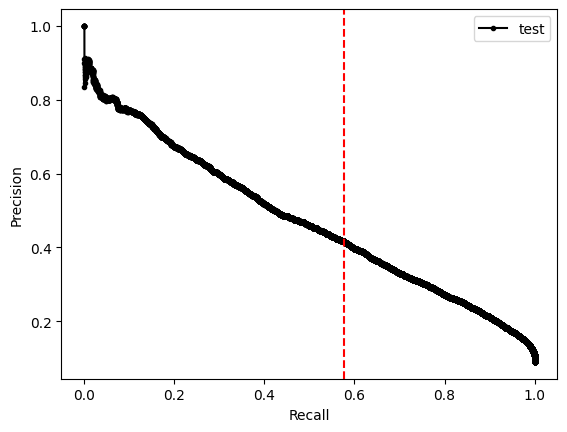

Best Threshold 0.7998495697975159 with F-Score 0.48366863905325447 for test dataset


In [46]:
# Precision recall plot for finding optimal threshold

import matplotlib.pyplot as plt
which_dataset = "val"  # test
which_dataset = "test"
dataset = val_dataset if which_dataset == "val" else test_dataset
dataloader = val_loader if which_dataset == "val" else test_loader

sigmoid = nn.Sigmoid()

total_probs = np.empty(0)
# total_labels = np.empty(0)  # don't need to have same order
model.eval()
# Calculate the probs
for batch in dataloader:
    samples, labels = batch['sequence'].to(device), batch['label'].to(device)

    outputs = model(samples)

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        outputs = sigmoid(outputs)

    total_probs = np.concatenate((total_probs, outputs.flatten().cpu().detach().numpy()))
    # total_labels = np.concatenate((total_labels, labels.flatten().cpu().detach().numpy()))

precisions, recalls, thresholds = precision_recall_curve(dataset.list2, total_probs)
# dataset.list2  # list of all labels

plt.plot(recalls, precisions, marker='.', label=which_dataset, color="black")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
fscores = (2 * precisions * recalls) / (precisions + recalls)

# Turn nan values to 0
fscores[np.isnan(fscores)] = 0

# locate the index of the largest f score
ix = np.argmax(fscores)
best_threshold = thresholds[ix]
plt.plot(recalls[ix], precisions[ix], color="red")
plt.axvline(recalls[ix], ls='--', color="red", label="Best F-Score")
# show the plot
plt.show()
print(f"Best Threshold {thresholds[ix]} with F-Score {fscores[ix]} for {which_dataset} dataset")
# Best Threshold 42.7
# 87.3 for val, 79.4 for test
# correct 80.4 val, 85.2 test  # now after fixing utils.compute_metrics(), although idt that affects this


In [47]:
# EVALUATE on test dataset
total_predictions = 0
total_correct = 0

model.eval()

CM = 0  # confusion matrix

print(f"Using threshold {best_threshold}")
for batch in test_loader:  # tqdm()

    test_samples, test_labels = batch['sequence'].to(device), batch['label'].to(device)
    test_outputs = model(test_samples)

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        test_outputs = sigmoid(test_outputs)

    test_preds = utils.get_preds(test_outputs, threshold=best_threshold)

    test_labels = test_labels.reshape(-1, 1).float()

    test_loss = loss_fn(test_outputs, test_labels).item()  # change tensor to single val

    total_predictions += len(test_outputs)

    CM += confusion_matrix(test_labels.flatten().cpu().detach().numpy(), test_preds.cpu().flatten().detach().numpy())

# Computer accuracy, precision, recall, and f1 metrics
acc_score, precision, recall, f1 = utils.compute_metrics(CM)

print(f"Final Test Accuracy: {acc_score * 100} %")
print(f"Final Test Precision: {precision * 100} %")
print(f"Final Test Recall: {recall * 100} %")
print(f"Final Test F1 Score: {f1 * 100} %")

if USING_WANDB:
    wandb.summary['test_accuracy'] = acc_score
    wandb.summary['test_precision'] = precision
    wandb.summary['test_recall'] = recall
    wandb.summary['test_f1_score'] = f1

    wandb.finish()

Using threshold 0.7998495697975159
Final Test Accuracy: 88.92002231463637 %
Final Test Precision: 41.64885496183206 %
Final Test Recall: 57.65004226542688 %
Final Test F1 Score: 48.360219819181 %


Error: You must call wandb.init() before wandb.summary['test_accuracy']

In [131]:
print(f"Note: Actual Test {len(acc_seq_test)} accessible and {len(not_seq_test)} notaccessible")

Note: Actual Test 7086 accessible and 71768 notaccessible


In [ ]:
# Potential solutions to out of gpu memory
# import gc
# gc.collect()
# with torch.no_grad():
#     torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)
# del total_outputs, total_labels

In [ ]:
# test on rest of nonaccessible
# rest_not_sequences, rest_not_labels, _ = dna_dataset.read_data_file(rest_notaccessible_file, accessible=False, shuffle=True)

In [ ]:
# # test on rest of nonaccessible
# if DOWNSAMPLE:
#     # rest_nonacc_dataset = dna_dataset.DNADataset(rest_not_sequences, rest_not_labels)
#     rest_notacc_loader = torch.utils.data.DataLoader(rest_notacc_dataset, batch_size=batch_size)#, shuffle=True)
#     # total_preds = torch.empty(0)  # tuples of probability, id
#     CM = 0
#     total_correct = 0
#     total_predictions = 0
#     model.eval()
#     for batch in rest_notacc_loader:  # tqdm()
#         samples, labels = batch["sequence"].to(device), batch['label']  # know it's all 0 labels
#         outputs = model(samples)
#         preds = utils.get_preds(outputs)
#         total_predictions += len(outputs)
#         CM += confusion_matrix(labels.cpu().flatten().detach().numpy(), preds.cpu().flatten().detach().numpy())
#     # Computer accuracy, precision, recall, and f1 metrics
#     acc_score, precision, recall, f1 = utils.compute_metrics(CM)
#     print(f"Rest not Accuracy: {acc_score * 100} %")
#     print(f"Rest not Precision: {precision * 100} %")
#     print(f"Rest not Recall: {recall * 100} %")
#     print(f"Rest not F1 Score: {f1 * 100} %")
#     # wandb.summary['rest_nonacc_accuracy'] = acc_score
#     # wandb.finish()

Save Model

In [34]:
# !rm -r pretrained
# !rm predictions.zip

In [37]:
# Create pretrained directory if not yet created
if not os.path.isdir(PRETRAINED_DIR):
    os.mkdir(PRETRAINED_DIR)

now = datetime.now()
datetime_str = now.strftime("%m-%d-%H-%M-%S")
model_save_path = os.path.join(
    PRETRAINED_DIR,
    f'{note}{datetime_str}-{model.__class__.__name__}-model-{learning_rate}lr-{epochs}epochs.pt'
)
print('model_save_path', model_save_path)

CNNModel.save_CNNModel(model_save_path, CNN)  # model
print(f"model saved at {datetime_str}")

model_save_path pretrained/test-list-0.01-weight-decay-adamW-sklearn type weight01-08-06-26-17-CNNModel-model-0.0001lr-20epochs.pt
model saved at 01-08-06-26-17


Load Model

In [ ]:
# Add the new path
model_save_path = ""
model = CNNModel.load_CNNModel(model_save_path)
model.to(device);

Inference on Competition File

In [38]:
# Load Competitation Data
# Set shuffle=False to save time, unnecessary for comp file
comp_sequences, _, comp_ids = dna_dataset.read_data_file(comp_file, labeled=False, shuffle=False)
competition_dataset = dna_dataset.DNADataset(comp_sequences, comp_ids, comp=True)
competition_loader = torch.utils.data.DataLoader(competition_dataset, batch_size=batch_size)
print("Competition dataset loaded.")

Competition dataset loaded.


In [49]:
probs = []  # tuples of probability, id

sigmoid = nn.Sigmoid()

model.eval()
for batch in competition_loader:  # tqdm()
    samples, ids = batch["sequence"].to(device), batch['id']  # not a tensor
    outputs = model(samples)

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        outputs = sigmoid(outputs)

    try:
        assert(len(outputs[outputs>1]) == 0 and len(outputs[outputs<0]) == 0)  # ensure all probs are [0,1]
    except:
        placeholder = 0
        # print(outputs[outputs>1][0])
        # print(outputs[outputs<0][0])

    out_list = outputs.tolist()
    for i in range(len(out_list)):
        probs.append((out_list[i], ids[i]))

print("Finished inference")

# print(np_probs[np_probs>0.0 and np_probs<1.0])

Finished inference


In [50]:
# View the results
np_probs = np.array(list(zip(*probs))[0])
not_probs = np_probs[np_probs<=0.7]
not_probs.sort()
acc_probs = np_probs[np_probs>0.7]
print("Predicted", len(acc_probs), "true values out of ", len(np_probs), " total", len(acc_probs) * 100 / len(np_probs), "percent")
print(f"Note: 10,000 / {len(competition_dataset)} is {10000 / len(competition_dataset):.4f}")
acc_probs[::-1].sort()
print()
print("not accessible probs", not_probs)
print("accessible probs", acc_probs)
assert(len(np_probs[np_probs>1]) == 0 and len(np_probs[np_probs<0]) == 0)  # ensure all probs are [0,1]

print()

probs.sort(reverse=True)
print("first 10\n", list(zip(*probs[:10]))[0])
print("last 10 of top 10000\n", list(zip(*probs[9990:10000]))[0])  # probs only

highest_probs = probs[:10000]  # top 10,000

Predicted 50137 true values out of  269315  total 18.61648998384791 percent
Note: 10,000 / 269315 is 0.0371

not accessible probs [8.54308052e-13 1.61152060e-12 2.39714563e-12 ... 6.99985147e-01
 6.99989736e-01 6.99994504e-01]
accessible probs [0.99999452 0.99999321 0.99998295 ... 0.70001566 0.70000958 0.70000666]

first 10
 ([0.9999945163726807], [0.9999932050704956], [0.9999829530715942], [0.9999785423278809], [0.9999747276306152], [0.9999709129333496], [0.9999673366546631], [0.9999644756317139], [0.9999603033065796], [0.9999583959579468])
last 10 of top 10000
 ([0.9676263332366943], [0.9676147103309631], [0.9676147103309631], [0.967614471912384], [0.9676129221916199], [0.9676119089126587], [0.9676008820533752], [0.9675981998443604], [0.9675949811935425], [0.9675704836845398])


In [51]:
with open(SOLUTION_FILE, "w") as f:
    for pair in highest_probs:
        f.write(pair[1])
        # f.write("a")
        f.write("\n")

In [52]:
zip_file_name = "predictions.zip"
!zip $zip_file_name $SOLUTION_FILE
!rm $SOLUTION_FILE

  adding: predictions.csv (deflated 65%)


In [53]:
# ONLY for use on google colab. download files
from google.colab import files
import os
model_file = os.path.join(PRETRAINED_DIR, os.listdir(PRETRAINED_DIR)[0])
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
from google.colab import files
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>